# Model Work 3 for DTC
Modeling Work 1 is mostly done onto all features. These models will have select features used instead as I believe there was a bunch of unnecessary noise in the models of Modeling Work 1

## Imports and functions

In [3]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
ft_df = pd.read_csv("../data/training_set_features.csv")
lbl_df = pd.read_csv("../data/training_set_labels.csv")
## Merging dfs
df_merged = ft_df.merge(lbl_df)

In [4]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [5]:
ft_df = pd.read_csv("../data/training_set_features.csv")
lbl_df = pd.read_csv("../data/training_set_labels.csv")
## Merging dfs
df_merged = ft_df.merge(lbl_df)

## Prepping Data Use

In [6]:
## Dropping:
# respondent_id: its just ids
# employment_occupation/industry: too many nulls, assuming imputing with most freq will give us wrong data
# health insurance: too many nulls again, cant really decide if they have or dont have insurance
df_noid = df_merged.drop(['respondent_id','employment_occupation','employment_industry','behavioral_antiviral_meds',
                          'household_children','household_adults','census_msa','rent_or_own', 'marital_status',
                         'health_insurance'], axis = 1)

## Creating Test Train Valid

In [7]:
# preparing X and y
X = df_noid.drop('h1n1_vaccine', axis = 1)
y = df_noid['h1n1_vaccine']

In [8]:
# initial split between test and rest. Final untouced data will be X_test/y_test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
# Splitting again for cross validation. X_train/X_valid will be used mostly
X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, random_state = 42)

In [9]:
print(f"Sum of X_'s: {len(X_test)+len(X_train)+len(X_valid)}")
print(f"Length of df: {len(df_noid)}")

# Just checking if logic of trian/test/split worked correctly

Sum of X_'s: 26707
Length of df: 26707


## Creating Initial Pipes

In [10]:
# Every feature has some kind of null. Will have to impute first.
# Making pipelines for imputers
# Will also scale here

subpipe_num = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy = 'median')),
    ('ss', StandardScaler())
])

subpipe_cat = Pipeline(steps = [
    ('cat_impute', SimpleImputer(strategy = 'most_frequent')),
    
    ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
])

In [11]:
# Col transformer will handle preprocessing
# Add model at end of the pipeline

CT = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, selector(dtype_include = np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include = object))
], remainder = 'passthrough')

## DTC Model no params + gridsearch after
No need for dummy again, have it in previous notebooks

In [12]:
dtc_smote_pipe = ImPipeline(steps = [
    ('ct', CT),
    ('sm', SMOTE(random_state = 42)),
    ('dtc_smote', DecisionTreeClassifier(random_state = 42))
])

In [13]:
dtc_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E9BE445400>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

CV Results for `dtc_smote_modelwithCV` model:
            0.77844 ± 0.00878 accuracy
        


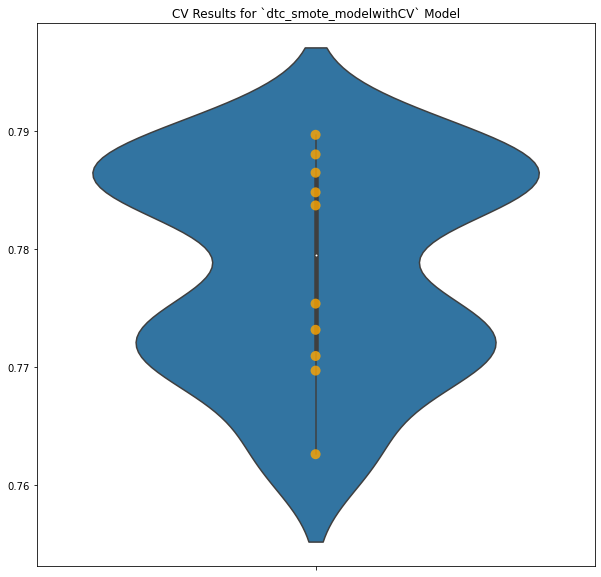

In [14]:
dtc_smote_cv = ModelWithCV(
    dtc_smote_pipe,
model_name = 'dtc_smote_modelwithCV',
X = X_train,
y = y_train)
fig, ax = plt.subplots(figsize = (10,10))
dtc_smote_cv.plot_cv(ax=ax)
dtc_smote_cv.print_cv_summary()

In [15]:
dtc_smote_cv.print_cv_summary()

CV Results for `dtc_smote_modelwithCV` model:
            0.77844 ± 0.00878 accuracy
        


In [16]:
dtc_smote_pipe.score(X_valid, y_valid)

0.7813280079880179

In [17]:
y_pred = dtc_smote_pipe.predict(X_valid)
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4781
           1       0.47      0.51      0.49      1228

    accuracy                           0.78      6009
   macro avg       0.67      0.68      0.68      6009
weighted avg       0.79      0.78      0.78      6009



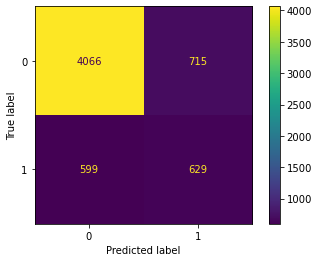

In [18]:
plot_confusion_matrix(dtc_smote_pipe, X_valid, y_valid)

### Gridsearching DTC

In [19]:
parameters = {'dtc_smote__criterion': ['gini'],
          'ct__subpipe_num__num_impute__strategy': ['mean'],
          'dtc_smote__min_samples_leaf': [40],
          'sm__k_neighbors': [3],
          'sm__sampling_strategy':[0.4287]}
#sampling_strategy = 0.4287
gs = GridSearchCV(estimator=dtc_smote_pipe,
                 param_grid=parameters,
                 cv=10)

In [20]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001E9BE445400>),
                                                                        ('subpipe_cat',
                                                                         Pip

In [21]:
gs.best_params_

{'ct__subpipe_num__num_impute__strategy': 'mean',
 'dtc_smote__criterion': 'gini',
 'dtc_smote__min_samples_leaf': 40,
 'sm__k_neighbors': 3,
 'sm__sampling_strategy': 0.4287}

CV Results for `gs_dtc_model` model:
            0.84063 ± 0.00704 accuracy
        


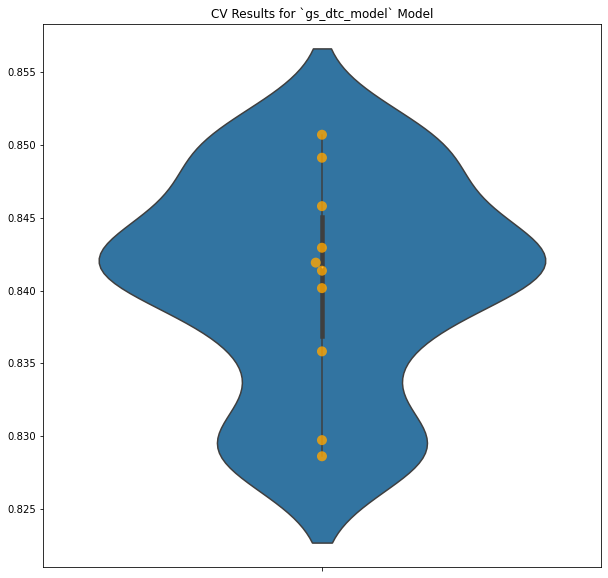

In [22]:
gs_pipe = ModelWithCV(
    gs.best_estimator_,
    model_name='gs_dtc_model',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

gs_pipe.plot_cv(ax=ax)
gs_pipe.print_cv_summary()

In [23]:
gs_pipe.print_cv_summary()

CV Results for `gs_dtc_model` model:
            0.84063 ± 0.00704 accuracy
        


In [24]:
gs.best_estimator_.score(X_valid, y_valid)

0.8467299051422865

In [25]:
y_pred = gs.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      4781
           1       0.64      0.58      0.61      1228

    accuracy                           0.85      6009
   macro avg       0.77      0.75      0.76      6009
weighted avg       0.84      0.85      0.84      6009



Iteration 5 Confusion Matrix


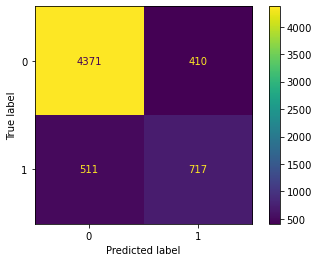

In [26]:
plot_confusion_matrix(gs.best_estimator_, X_valid, y_valid)
print(f"Iteration 5 Confusion Matrix")
#plt.savefig('Modeling_Work_DTC_best.png')

# Conclusion and final model:

## Thoughts before running final model.

DTC better for predicting will get vaccinated.
Logreg better for predicting not get vaccinated.
For the sake of being able to predict who will get vaccinated, want those metrics to use for future planning.

In [27]:
final_model = gs.best_estimator_

In [28]:
final_model.fit(X_train_temp, y_train_temp)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E9C01DA3D0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                        

CV Results for `final_model_cv_graph` model:
            0.84063 ± 0.00704 accuracy
        


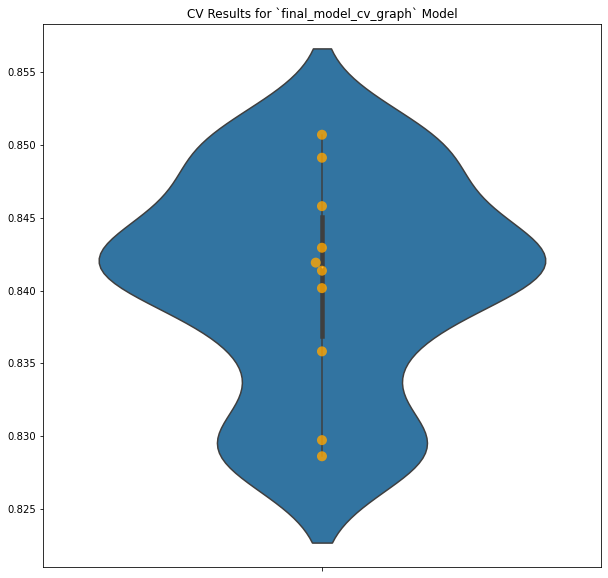

In [29]:
final_model_cv = ModelWithCV(
    final_model,
    model_name='final_model_cv_graph',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

final_model_cv.plot_cv(ax=ax)
final_model_cv.print_cv_summary()

In [30]:
final_model_cv.print_cv_summary()

CV Results for `final_model_cv_graph` model:
            0.84063 ± 0.00704 accuracy
        


In [31]:
final_model.score(X_test, y_test)

0.845376263571696

In [32]:
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2099
           1       0.65      0.60      0.62       572

    accuracy                           0.85      2671
   macro avg       0.77      0.76      0.76      2671
weighted avg       0.84      0.85      0.84      2671



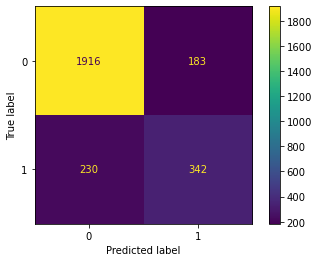

In [33]:
plot_confusion_matrix(final_model, X_test, y_test)
#plt.savefig('final_model_conf.png')

Final model score: 84.5% accurate, more correct 'yes vaccinated' counts than logreg model

In [34]:
accuracy_score(y_test, y_pred)

0.845376263571696

In [35]:
f1_score(y_test, y_pred)

0.6235186873290793

In [36]:
precision_score(y_test, y_pred)

0.6514285714285715

In [37]:
recall_score(y_test, y_pred)

0.5979020979020979